# qm7

In [20]:
from deepchem.molnet.load_function.qm7_datasets import load_qm7, _QM7Loader
import deepchem as dc

In [21]:
tasks, datasets, transformers= dc.molnet.load_qm7(featurizer=dc.feat.CoulombMatrix(23), data_dir='./', save_dir='./')

In [22]:
train_dataset, valid_dataset, test_dataset = datasets

In [23]:
test_dataset

<DiskDataset X.shape: (684, 23, 23), y.shape: (684, 1), w.shape: (684, 1), ids: ['[H]C([H])=C([H])C#C[C@]1([H])N([H])C1([H])[H]'
 '[H]OC([H])([H])[C@@]1([H])C([H])([H])O[C@]1([H])C([H])([H])[H]'
 '[H]C([H])=C([H])c1c([H])noc1[H]' ...
 '[H]C([H])=C([H])C1([H])C([H])([H])N(C([H])([H])[H])C1([H])[H]'
 '[H]N1C([H])([H])[C@]1([H])C(=O)C([H])([H])[H]'
 '[H][C]([H])[N]N([H])C([H])([H])C([H])([H])C([H])([H])[H]'], task_names: ['u0_atom']>

In [24]:
train_dataset

<DiskDataset X.shape: (5470, 23, 23), y.shape: (5470, 1), w.shape: (5470, 1), task_names: ['u0_atom']>

CNN

In [29]:
model = dc.models.CNN(n_tasks=1, n_features=23, dims=1, kernel_size=3, mode='regression')

In [30]:
print('train set roc score:', model.fit(train_dataset, nb_epoch=10))
print('test set roc score:', model.fit(test_dataset, nb_epoch=10))

train set roc score: 0.8109613037109376
test set roc score: 0.8632195472717286


DTNNModel

In [6]:
model = dc.models.DTNNModel(n_tasks=1, n_features=23, dims=1, kernel_size=3, mode='regression')

In [7]:
print('train set roc score:', model.fit(train_dataset, nb_epoch=10))
print('test set roc score:', model.fit(test_dataset, nb_epoch=10))

C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dtnn_step_1/Reshape_5:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dtnn_step_1/Reshape_4:0", shape=(None, 60), dtype=float32), dense_shape=Tensor("gradient_tape/model/dtnn_step_1/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dtnn_step/Reshape_5:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dtnn_step/Reshape_4:0", shape=(None, 60), dtype=float32), dense_shape=Tensor("gradient_tape/model/dtnn_step/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a lar

train set roc score: 0.7623508453369141
test set roc score: 0.7859579086303711


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import deepchem as dc
from deepchem.models.normalizing_flows import NormalizingFlow, NormalizingFlowModel
from deepchem.models.optimizers import Adam
from deepchem.data import NumpyDataset
from deepchem.splits import RandomSplitter
from deepchem.molnet import load_tox21

import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from IPython.display import Image, display

import selfies as sf

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

tfk.backend.set_floatx('float64')

Molecular visualization(references:github)

In [42]:
tasks, datasets, transformers = dc.molnet.load_qm7(featurizer='ECFP', data_dir='./', save_dir='./')
df = pd.DataFrame(data={'smiles': datasets[0].ids})

In [43]:
data = df[['smiles']].sample(2500, random_state=42)

In [46]:
sf.set_semantic_constraints()  # reset constraints
constraints = sf.get_semantic_constraints()
constraints['?'] = 3

sf.set_semantic_constraints(constraints)
constraints

{'H': 1,
 'F': 1,
 'Cl': 1,
 'Br': 1,
 'I': 1,
 'B': 3,
 'B+1': 2,
 'B-1': 4,
 'O': 2,
 'O+1': 3,
 'O-1': 1,
 'N': 3,
 'N+1': 4,
 'N-1': 2,
 'C': 4,
 'C+1': 5,
 'C-1': 3,
 'P': 5,
 'P+1': 6,
 'P-1': 4,
 'S': 6,
 'S+1': 7,
 'S-1': 5,
 '?': 3}

In [47]:
def preprocess_smiles(smiles):
  return sf.encoder(smiles)  

def keys_int(symbol_to_int):
  d={}
  i=0
  for key in symbol_to_int.keys():
    d[i]=key
    i+=1
  return d

data['selfies'] = data['smiles'].apply(preprocess_smiles)

In [48]:
data['len'] = data['smiles'].apply(lambda x: len(x))
data.sort_values(by='len').head()

,smiles,selfies,len
2252,[H]C#CC#N,[H][C][#C][C][#N],9
2154,[H]C#CC#CC#N,[H][C][#C][C][#C][C][#N],12
2231,[H]C#CC#CC#C[H],[H][C][#C][C][#C][C][#C][H],15
2927,[H]C#Cc1nsnc1[H],[H][C][#C][C][=N][S][N][=C][Ring1][Branch1][H],16
1580,[H]C#CC#CC([H])=O,[H][C][#C][C][#C][C][Branch1][C][H][=O],17


In [49]:
selfies_list = np.asanyarray(data.selfies)
selfies_alphabet = sf.get_alphabet_from_selfies(selfies_list)
selfies_alphabet.add('[nop]')  # Add the "no operation" symbol as a padding character
selfies_alphabet.add('.') 
selfies_alphabet = list(sorted(selfies_alphabet))
largest_selfie_len = max(sf.len_selfies(s) for s in selfies_list)
symbol_to_int = dict((c, i) for i, c in enumerate(selfies_alphabet))
int_mol=keys_int(symbol_to_int)

In [50]:
onehots=sf.batch_selfies_to_flat_hot(selfies_list, symbol_to_int,largest_selfie_len)

In [51]:
input_tensor = tf.convert_to_tensor(onehots, dtype='float64')
noise_tensor = tf.random.uniform(shape=input_tensor.shape, minval=0, maxval=1, dtype='float64')
dequantized_data = tf.add(input_tensor, noise_tensor)

In [52]:
ds = NumpyDataset(dequantized_data)  # Create a DeepChem dataset
splitter = RandomSplitter()
train, val, test = splitter.train_valid_test_split(dataset=ds, seed=42)
train_idx, val_idx, test_idx = splitter.split(dataset=ds, seed=42)

dim = len(train.X[0])  # length of one-hot encoded vectors
train.X.shape  # 2000 samples, N-dimensional one-hot vectors that represent molecules

(2000, 1862)

In [53]:
# SMILES strings of training data
train_smiles = data['smiles'].iloc[train_idx].values

In [54]:
base_dist = tfd.MultivariateNormalDiag(loc=np.zeros(dim), scale_diag=np.ones(dim))

if dim % 2 == 0:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2, dim), np.arange(0, dim / 2))),
                                  tf.int32)
else:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2 + 1, dim), np.arange(0, dim / 2))), tf.int32)

In [55]:
num_layers = 8
flow_layers = []

Made = tfb.AutoregressiveNetwork(params=2,
                                 hidden_units=[512, 512], activation='relu')

for i in range(num_layers):
    flow_layers.append(        
        (tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=Made)
    ))

    permutation = tf.cast(np.random.permutation(np.arange(0, dim)), tf.int32)
    
    flow_layers.append(tfb.Permute(permutation=permutation))
    
#     if (i + 1) % int(2) == 0:
#         flow_layers.append(tfb.BatchNormalization())

In [56]:
%%time
nf = NormalizingFlow(base_distribution=base_dist,
                    flow_layers=flow_layers)

Wall time: 28 ms


In [57]:
nfm = NormalizingFlowModel(nf, learning_rate=1e-4, batch_size=128)

In [58]:
losses = []
val_losses = []

In [59]:
%%time
max_epochs = 10 # maximum number of epochs of the training

for epoch in range(max_epochs):
  loss = nfm.fit(train, nb_epoch=1, all_losses=losses)
  val_loss = nfm.create_nll(val.X)
  val_losses.append(val_loss.numpy())

Wall time: 1min 29s


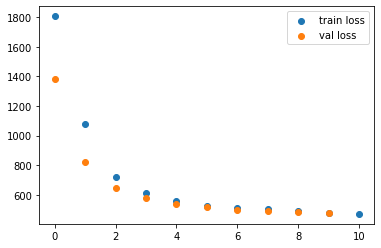

In [60]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

In [61]:
generated_samples = nfm.flow.sample(10)  # generative modeling
log_probs = nfm.flow.log_prob(generated_samples)  # probability density estimation

In [62]:
mols = tf.math.floor(generated_samples)  # quantize data
mols = tf.clip_by_value(mols, 0, 1)  # Set negative values to 0 and values > 1 to 1
mols_list = mols.numpy().tolist()

# Add padding characters if needed
for mol in mols_list:
  for i in range(largest_selfie_len):
    row = mol[len(selfies_alphabet) * i: len(selfies_alphabet) * (i + 1)]
    if all(elem == 0 for elem in row):
      mol[len(selfies_alphabet) * (i+1) - 1] = 1

In [63]:
mols=sf.batch_flat_hot_to_selfies(mols_list, int_mol)

In [64]:
from rdkit import RDLogger  
from rdkit import Chem
RDLogger.DisableLog('rdApp.*')  # suppress error messages

valid_count = 0
valid_selfies, invalid_selfies = [], []
for idx, selfies in enumerate(mols):
  try:
    if Chem.MolFromSmiles(sf.decoder(mols[idx]), sanitize=True) is not None:
        valid_count += 1
        valid_selfies.append(selfies)
    else:
      invalid_selfies.append(selfies)
  except Exception:
    pass
print('%.2f' % (valid_count / len(mols)),  '% of generated samples are valid molecules.')

1.00 % of generated samples are valid molecules.


In [65]:
gen_mols = [Chem.MolFromSmiles(sf.decoder(vs)) for vs in valid_selfies]

In [66]:
def display_images(filenames):
    """Helper to pretty-print images."""
    for file in filenames:
      display(Image(file))

def mols_to_pngs(mols, basename="generated_mol"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

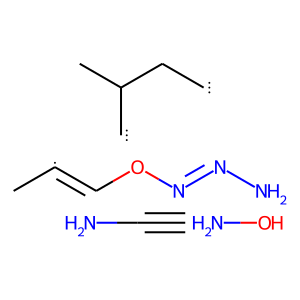

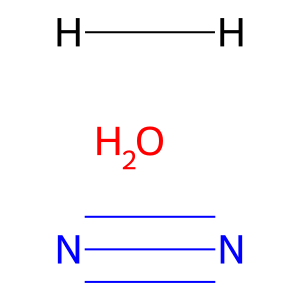

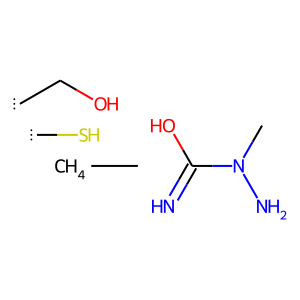

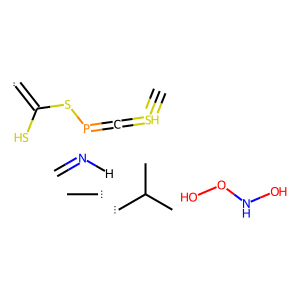

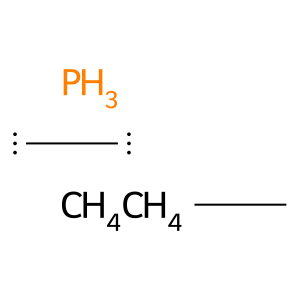

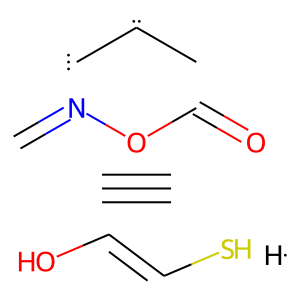

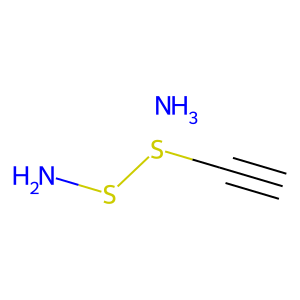

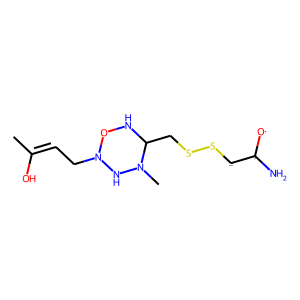

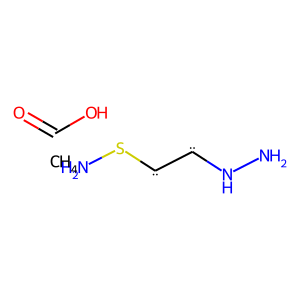

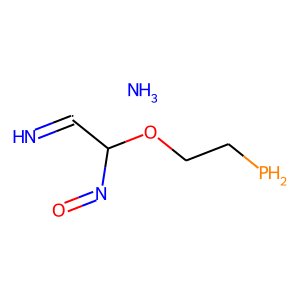

In [67]:
display_mols = []
for i in range(10):
  display_mols.append(gen_mols[i])

display_images(mols_to_pngs(display_mols))